In [1]:
import os
os.chdir('../../../')

In [2]:
import torch.utils.data as data
import numpy as np
from src.credential_classifier.bit_pytorch.grid_divider import read_img, coord2pixel, topo2pixel
from src.layout_matcher.topology import knn_matrix
from src.layout_matcher.misc import preprocess
from utils import read_txt, read_txt_screenshot
import torchvision.transforms as transform
import torch

import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [66]:
class HybridLoaderV2(data.Dataset):
    
    def __init__(self, img_folder: str, annot_path: str):
        self.img_folder = img_folder
        self.annot_path = annot_path
        self.num_imgs, self.labels, self.paths, self.preprocess_coordinates, self.img_classes = read_txt(annot_path)

        self.classes = {'credential': 0, 'noncredential': 1}
        self.transform = transform.Compose([transform.Resize((256, 256)),
                                            transform.ToTensor()])

    def __getitem__(self, item: int):

        image_file = list(set(self.paths))[item] # image path
        img_label = self.classes[np.asarray(self.labels)[np.asarray(self.paths) == image_file][0]] # credential/non-credential

        img_coords = np.asarray(self.preprocess_coordinates)[np.asarray(self.paths) == image_file] # box coordinates
        img_classes = np.asarray(self.img_classes)[np.asarray(self.paths) == image_file] # box types
        if len(img_coords) == 0:
            raise IndexError('list index out of range')
            
        # remove no width/no height coords
        img_classes = np.asarray([cls for i, cls in enumerate(img_classes) if (img_coords[i][2]-img_coords[i][0])*(img_coords[i][3]-img_coords[i][1]) > 0])
        img_coords = np.asarray([c for c in img_coords if (c[2]-c[0])*(c[3]-c[1]) > 0])
        
        # original image shape is 3xHxW
        image = Image.open(os.path.join(self.img_folder, image_file+'.png')).convert('RGB')
        shot_size = image.size[:2][::-1]
        image = self.transform(image) 
        
        # append class channels
        grid_tensor = coord2pixel(img_path=os.path.join(self.img_folder, image_file+'.png'),
                                  coords=img_coords, 
                                  types=img_classes)
    
        image = torch.cat((image.double(), grid_tensor), dim=0)
        
        # get topological tensor
        compos = img_coords[img_classes != 'block'] # remove block
        resize_compos = preprocess(shot_size, compos) # Rescale all coords to be [0, 100], used to compute KNN matrix
        if len(compos) > 0:
            box_matrix, _ = knn_matrix(compos=resize_compos, k=3, norm_method='log') # layout extraction -- KNN matrix computation
            box_matrix = box_matrix.reshape(box_matrix.shape[0], -1) # reshape to be Nx(KxZ)

            topo_tensor = topo2pixel(img_path=os.path.join(self.img_folder, image_file+'.png'), 
                                     coords=compos, 
                                     knn_matrix=box_matrix).double()
        else:
            topo_tensor = torch.zeros((12, 256, 256)).double() # no component
        
        return image, topo_tensor, img_label

    def __len__(self):
        return self.num_imgs

In [67]:
if __name__ == '__main__':
    
    train_set_orig = HybridLoaderV2(img_folder='datasets/train_imgs',
                            annot_path='datasets/train_coords.txt')
        

    train_loader = torch.utils.data.DataLoader(
        train_set_orig, batch_size=32, drop_last=False, shuffle=False)

#     val_loader = torch.utils.data.DataLoader(
#         test_set, batch_size=32, drop_last=False, shuffle=False)

    # from bit_pytorch.train import recycle
#     for i, (x, y) in enumerate(train_loader):
#         print(x.shape)
    #
    # # print(len(train_set))
    # for x, y in train_loader:
    #     # print(x)
    #     print(x.shape)
    #     print(y)
    #     break
    #
    # for x, y in val_loader:
    #     # print(x)
    #     print(x.shape)
    #     print(y)
    #     break
    #
    #
    # #     plt.imshow(Image.open(os.path.join('./data/first_round_3k3k/all_imgs', file_path[0]+'.png')))
    # #     plt.show()
    # #     break
    # #     print(x)
    # #     print(y)
    # #     break

In [68]:
haha = train_set_orig[6]

In [69]:
haha[0].shape

torch.Size([8, 256, 256])

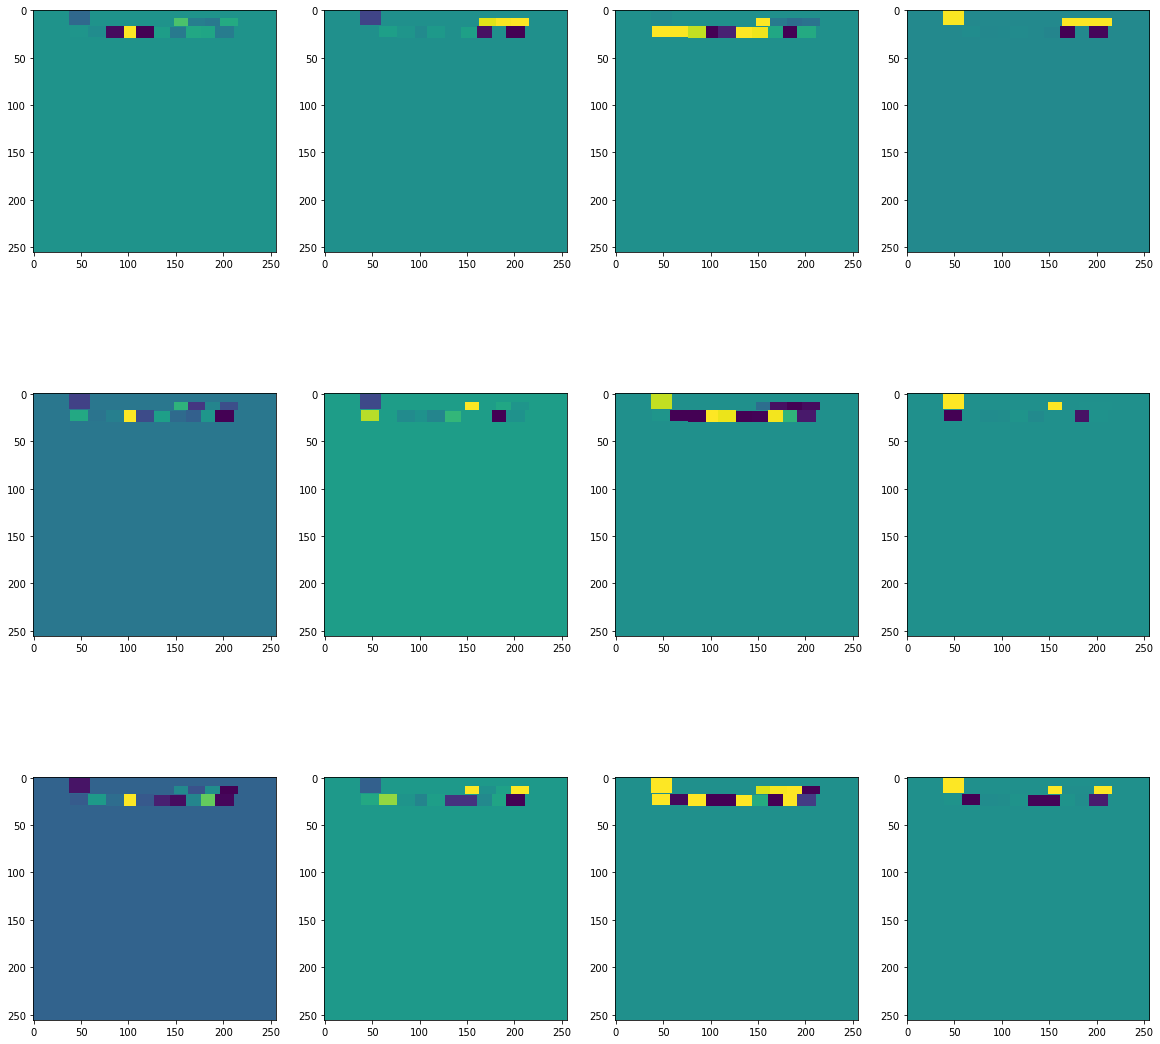

In [75]:
fig = plt.figure(figsize=(20,20))
plt.subplot(341)
plt.imshow(haha[1][0])
plt.subplot(342)
plt.imshow(haha[1][1])
plt.subplot(343)
plt.imshow(haha[1][2])
plt.subplot(344)
plt.imshow(haha[1][3])
plt.subplot(345)
plt.imshow(haha[1][4])
plt.subplot(346)
plt.imshow(haha[1][5])
plt.subplot(347)
plt.imshow(haha[1][6])
plt.subplot(348)
plt.imshow(haha[1][7])
plt.subplot(349)
plt.imshow(haha[1][8])
ax2 = fig.add_subplot(3, 4, 10)
ax2.imshow(haha[1][9])
ax3 = fig.add_subplot(3, 4, 11)
ax3.imshow(haha[1][10])
ax3 = fig.add_subplot(3, 4, 12)
ax3.imshow(haha[1][11])

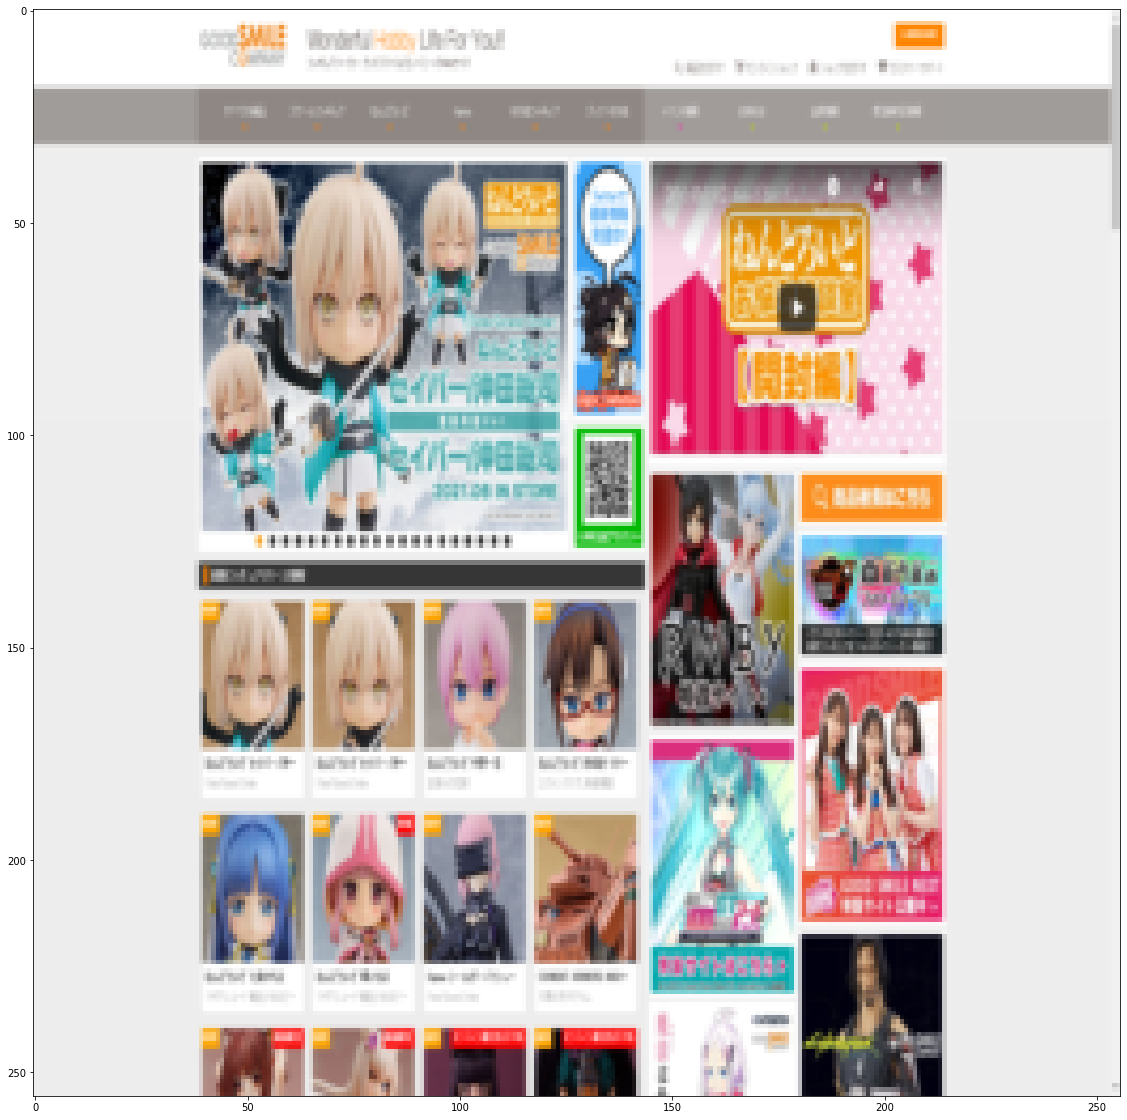

In [72]:
plt.figure(figsize=(20,20))
plt.imshow(haha[0][:3, :, :].permute(1,2,0))

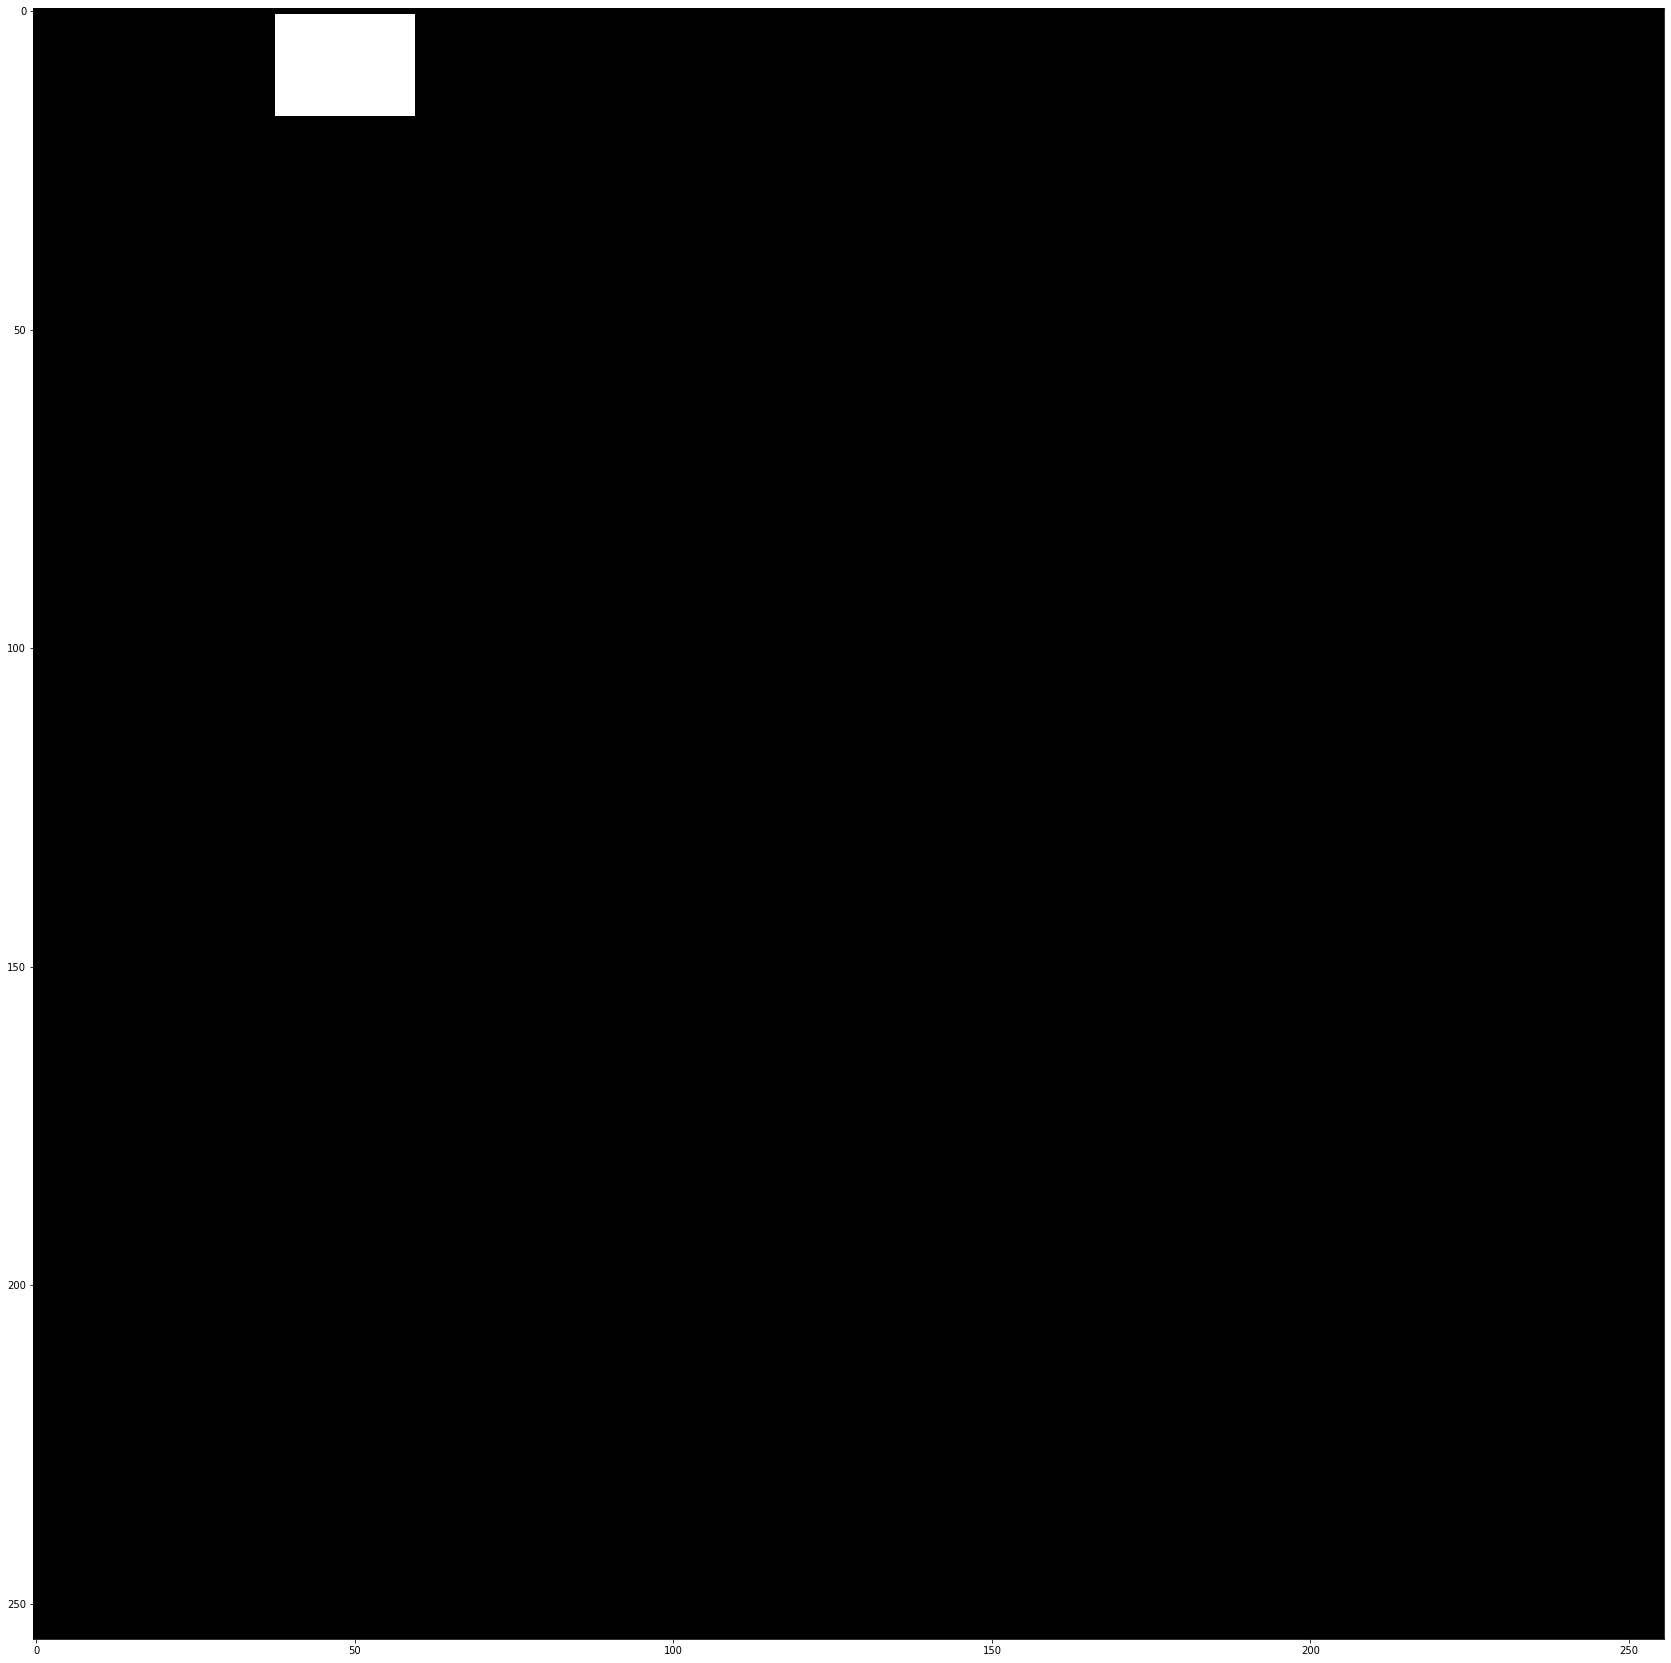

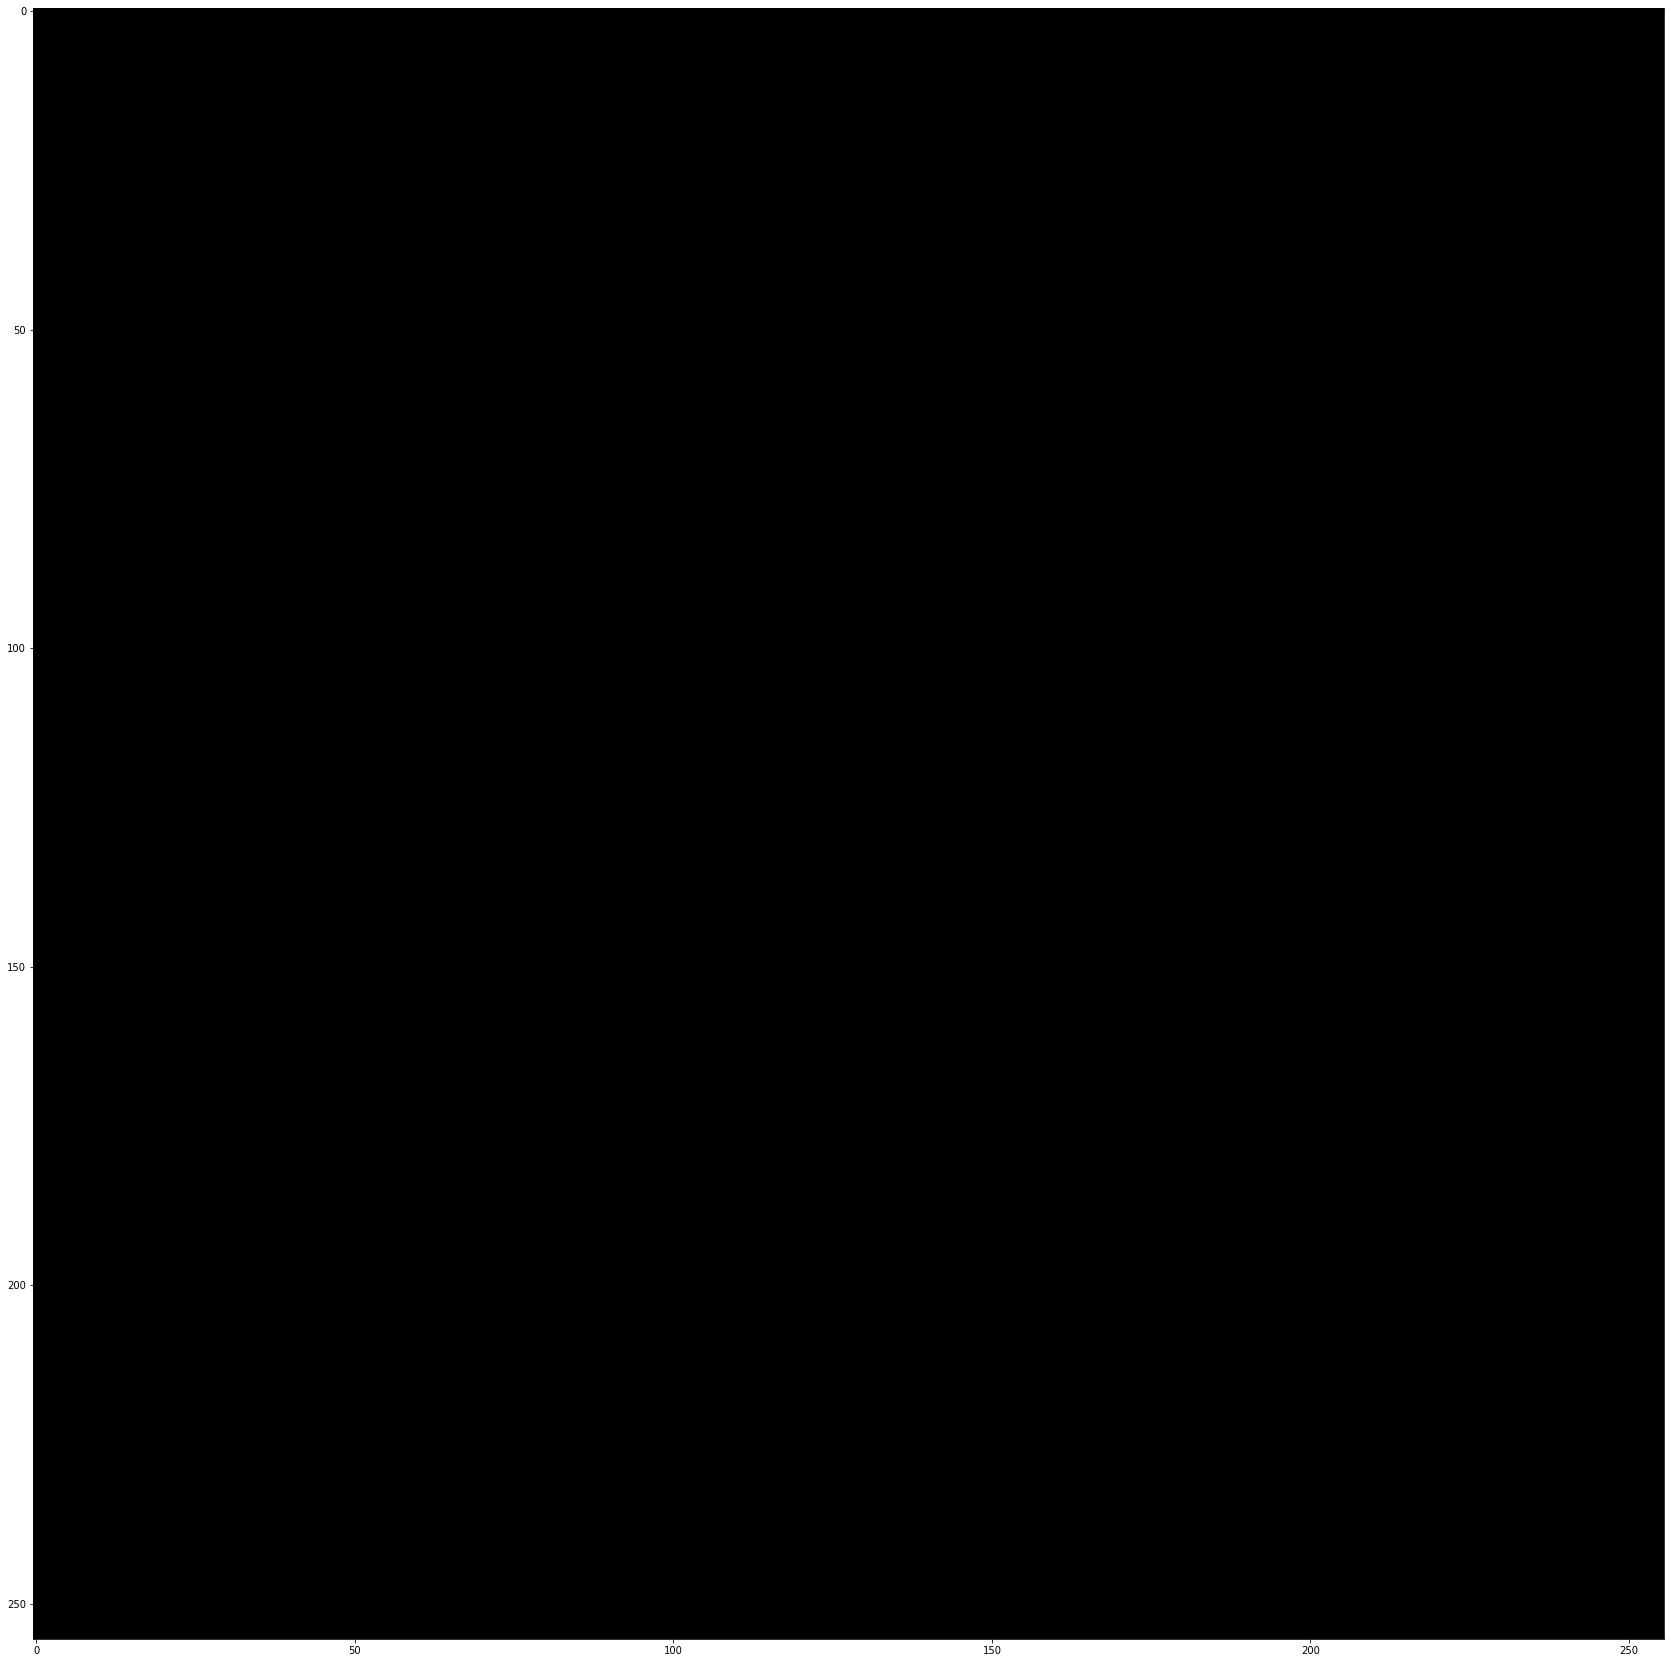

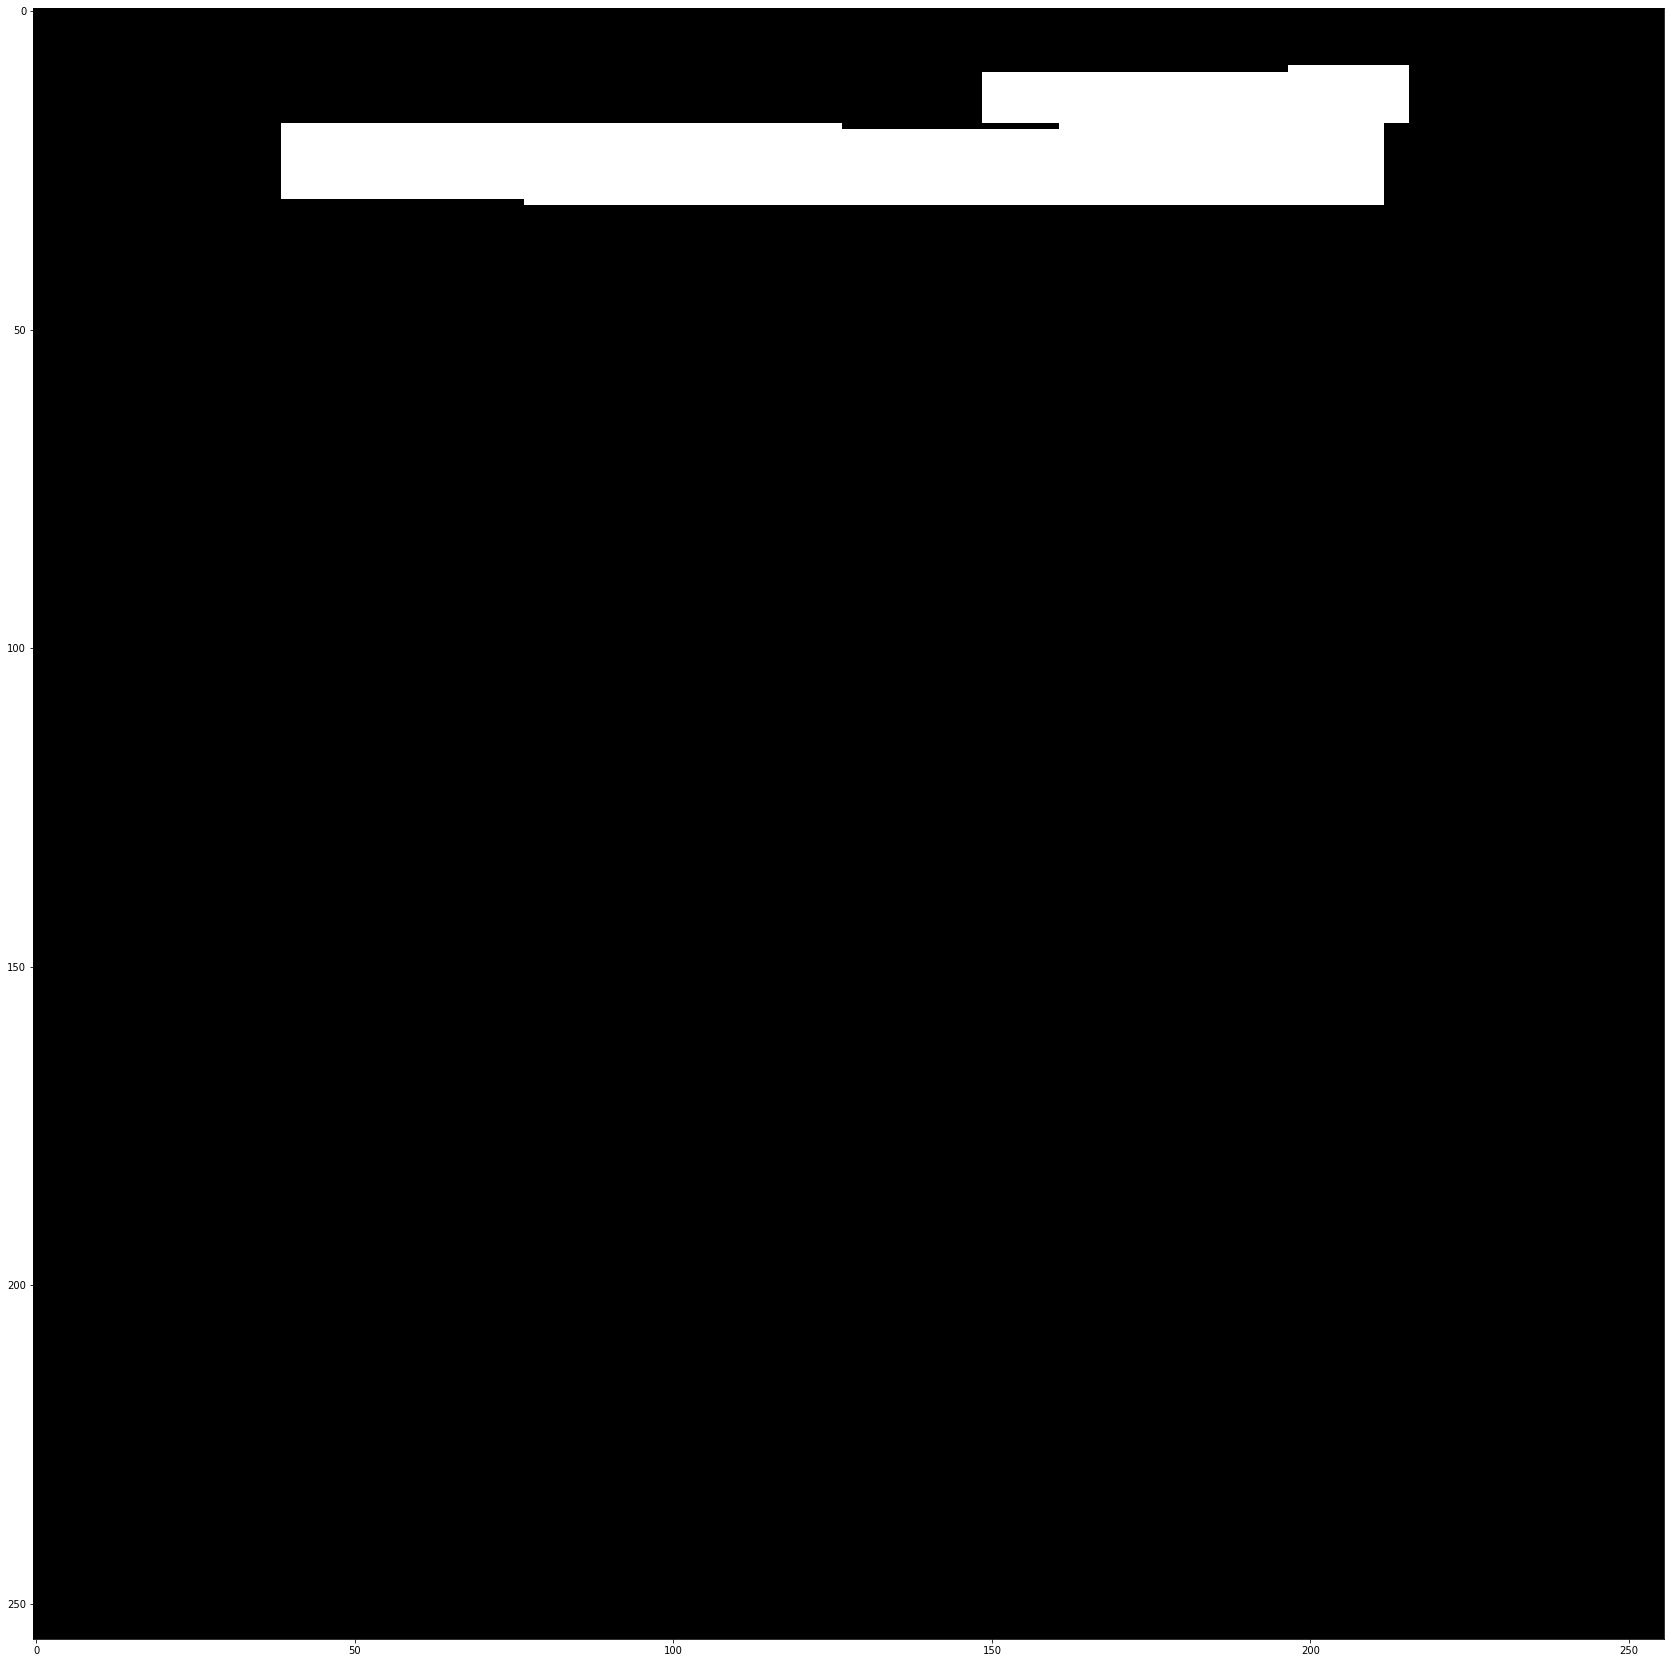

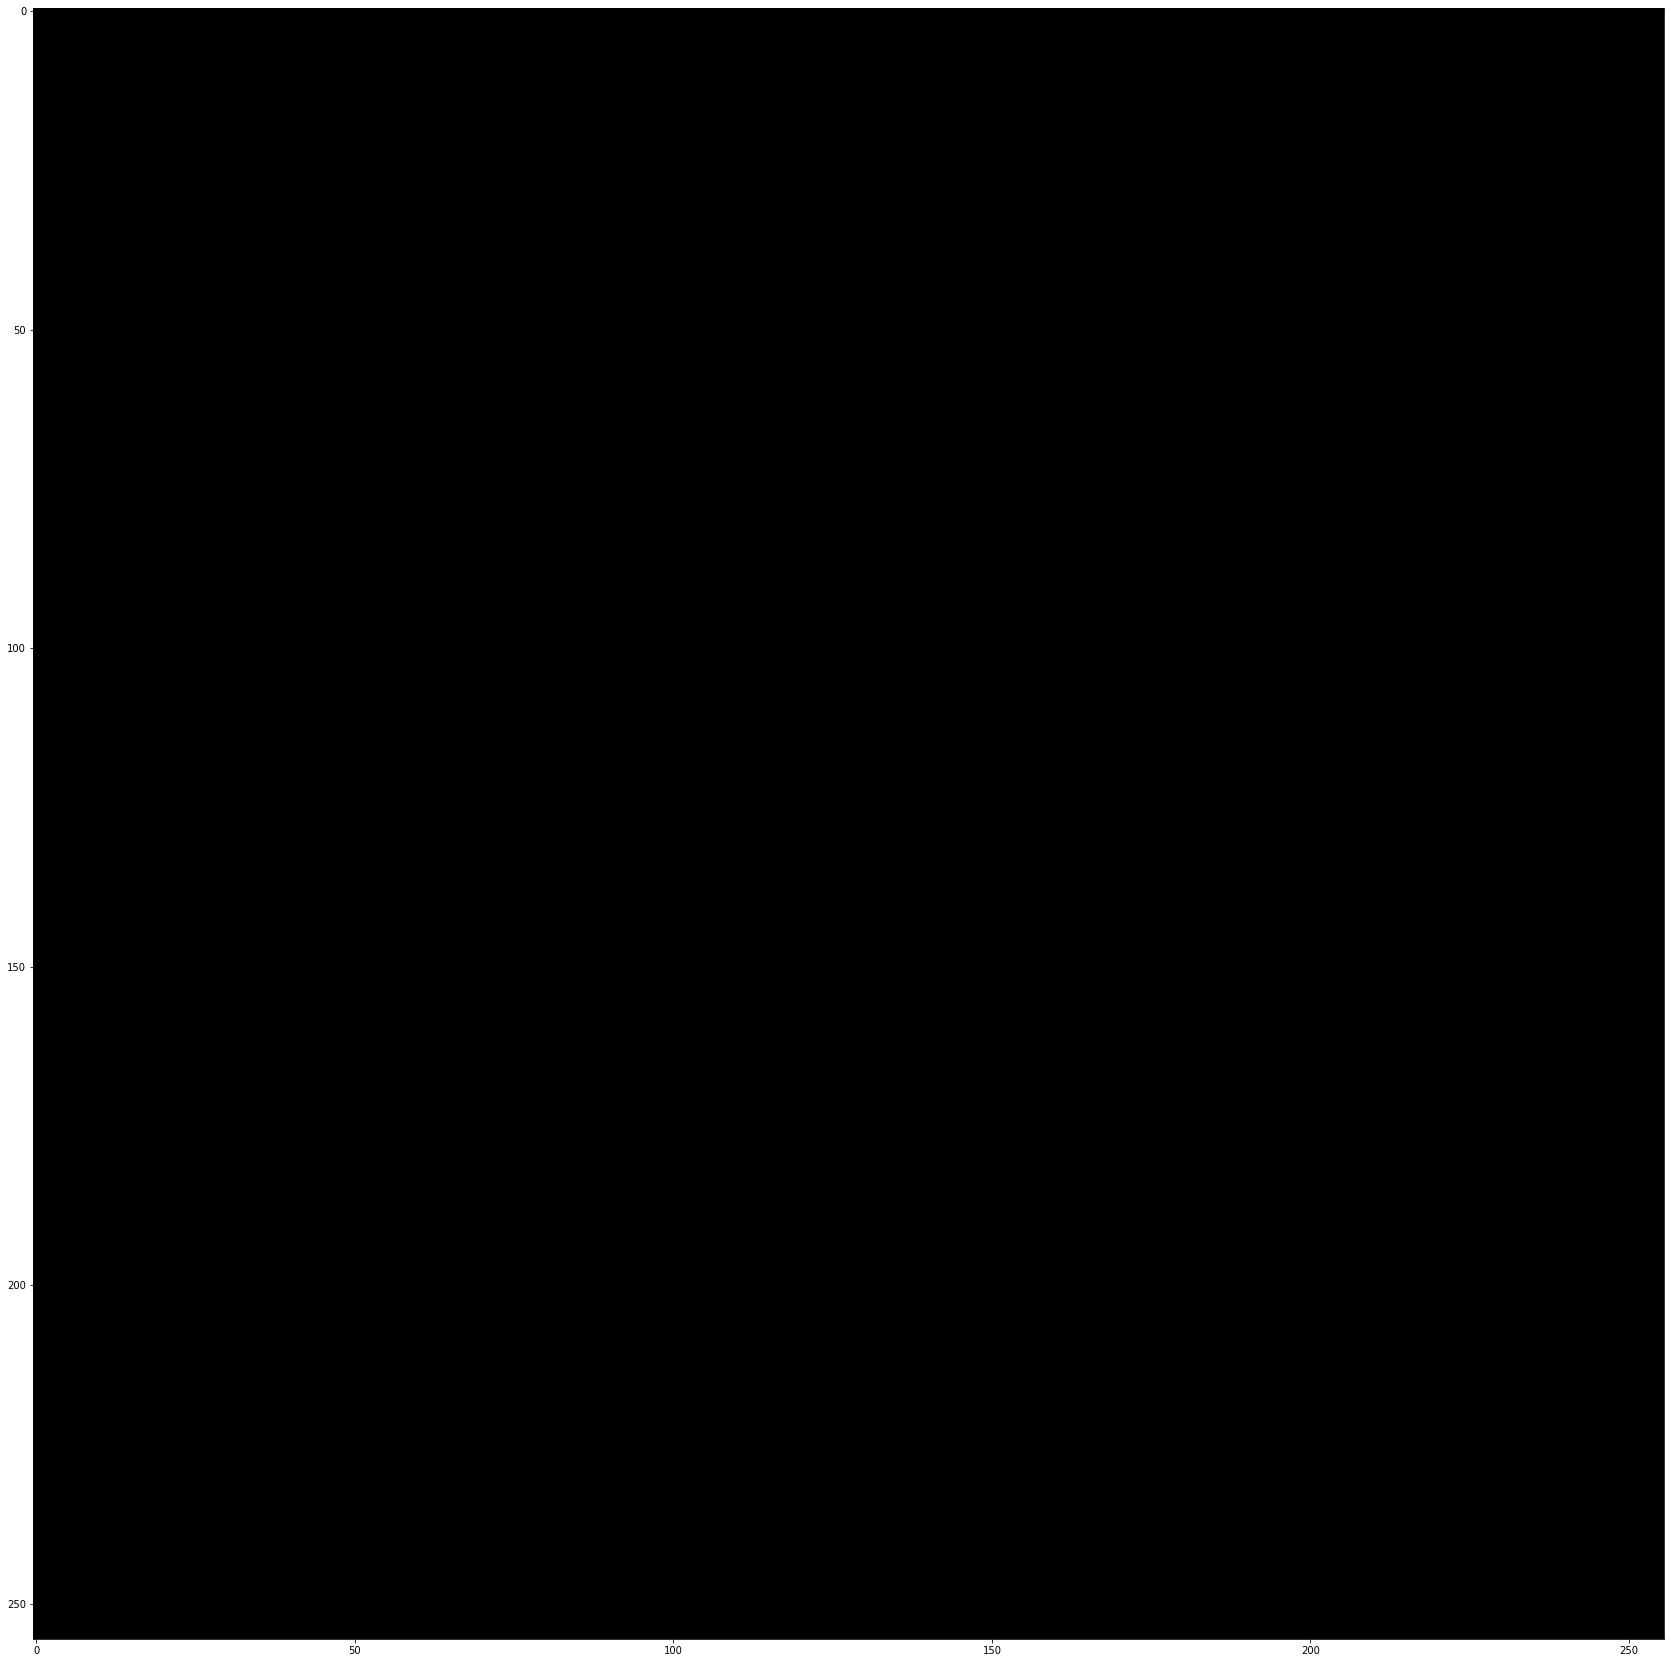

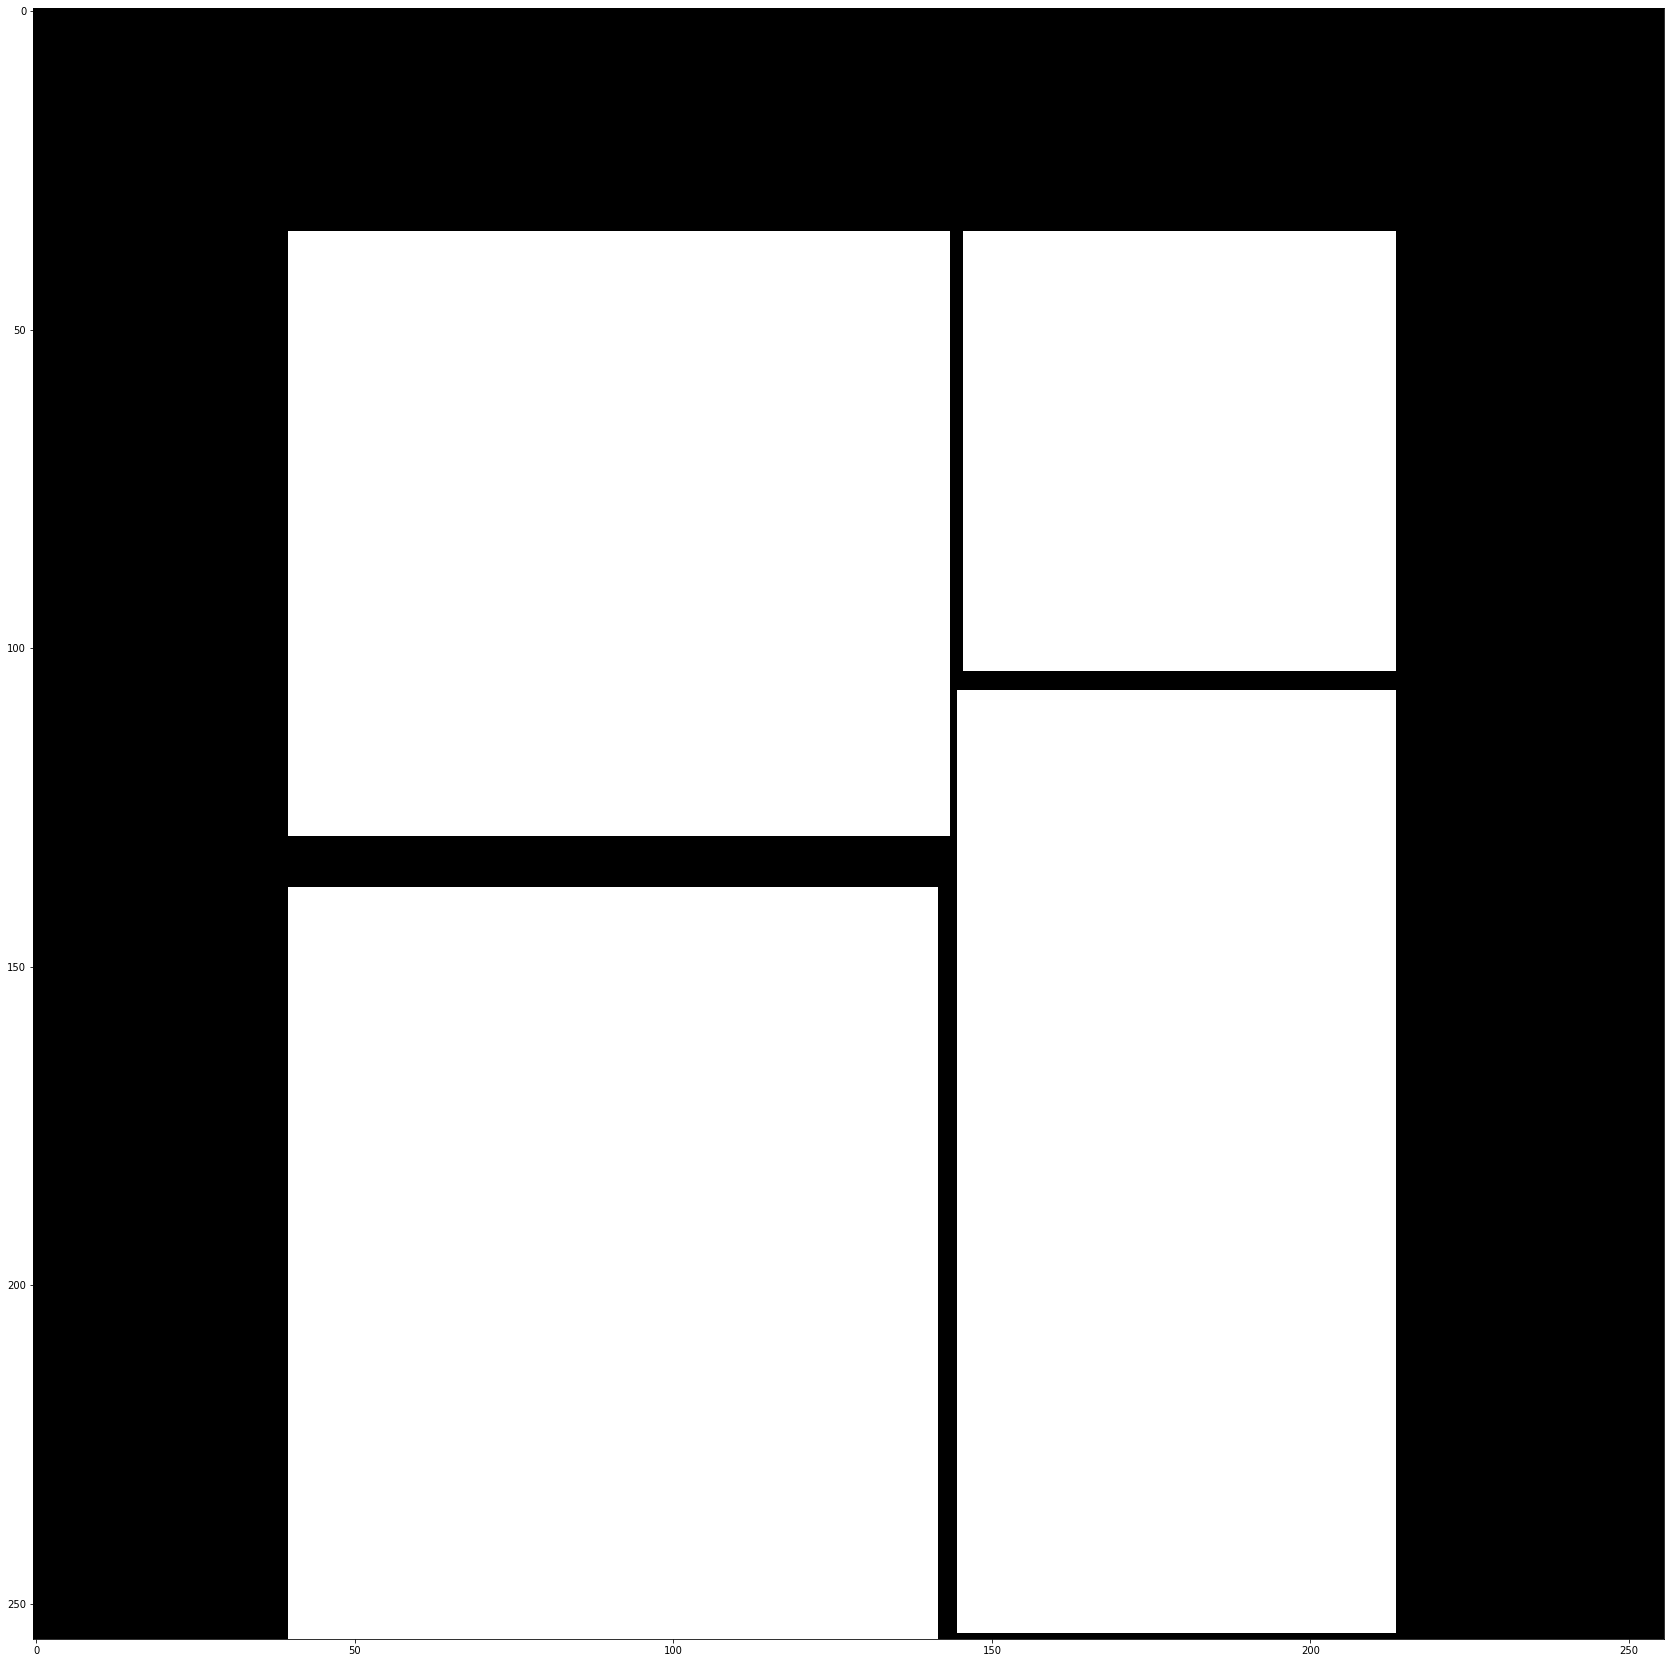

In [74]:
plt.figure(figsize=(30, 30))
plt.imshow(haha[0][3], cmap='gray')
plt.show()
plt.figure(figsize=(30, 30))
plt.imshow(haha[0][4], cmap='gray')
plt.show()
plt.figure(figsize=(30, 30))
plt.imshow(haha[0][5], cmap='gray')
plt.show()
plt.figure(figsize=(30, 30))
plt.imshow(haha[0][6], cmap='gray')
plt.show()
plt.figure(figsize=(30, 30))
plt.imshow(haha[0][7], cmap='gray')
plt.show()